Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# modify to where you store your project data including utils
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: './utils.py' and './utils.py' are the same file
cp: './images' and './images' are the same file


In [2]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17


### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [83]:
def score_projection(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  # TO DO
  threshold = 5
  distances = np.sqrt(np.sum((pt1 - pt2)**2, axis=0))
    
  inliers = distances < threshold

  score = np.sum(inliers)

  return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [84]:
def computeHomography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
    
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO

    if normalization_func is not None:
        pts1, T1 = normalization_func(pts1)
        pts2, T2 = normalization_func(pts2)

    A = []

    for i in range(pts1.shape[1]):
        x1, y1 = pts1[0, i], pts1[1, i]
        x2, y2 = pts2[0, i], pts2[1, i]
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    if normalization_func is not None:
        H = np.dot(np.linalg.inv(T2), np.dot(H, T1))

    return H / H[-1, -1]


best score: 222.000000
[[ 1.00000000e+00  3.11256543e-02 -2.03694390e+02]
 [ 1.29291683e-02  9.35763967e-01 -1.48008822e+01]
 [ 3.38126554e-04  1.71366882e-05  8.25810858e-01]]


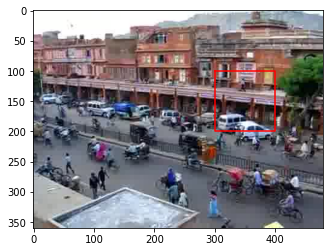

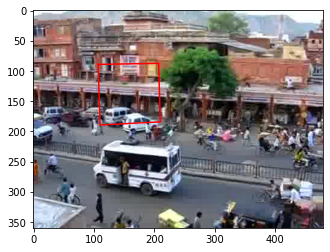

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1, im2, computeHomography)
print(H / H.max())

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:, :, [2, 1, 0]])
plt.plot(box_pts[0, :], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2
box_pts_proj = np.dot(H, box_pts)
box_pts_proj /= box_pts_proj[2, :]

plt.figure()
plt.imshow(im2[:, :, [2, 1, 0]])
plt.plot(box_pts_proj[0, :], box_pts_proj[1, :], 'r-')
plt.show()


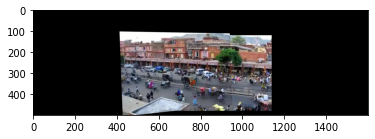

In [86]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float32)

# TO DO: warp and blend the two images
im1_warped = cv2.warpPerspective(im1, np.dot(Tr, H), (projectedWidth, projectedHeight))

im2_warped = cv2.warpPerspective(im2, Tr, (projectedWidth, projectedHeight))

blended_image = np.where(im1_warped != 0, im1_warped, im2_warped)

plt.figure()
plt.imshow(blended_image[:, :, [2, 1, 0]])
plt.show()




### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 222.000000
best score: 214.000000
best score: 257.000000
best score: 151.000000


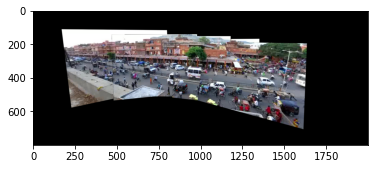

In [87]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]), dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 2000
projectedHeight = 800

Tr = np.array([[1, 0, 700], [0, 1, 150], [0, 0, 1]], dtype=np.float32)

homographies = [None] * 5
homographies[2] = np.eye(3)

homographies[1] = auto_homography(frames[1], frames[2], computeHomography)
homographies[3] = auto_homography(frames[3], frames[2], computeHomography)

H_90_to_270 = auto_homography(frames[0], frames[1], computeHomography)
H_270_to_450 = homographies[1]
homographies[0] = np.dot(H_270_to_450, H_90_to_270)

H_630_to_810 = auto_homography(frames[4], frames[3], computeHomography)
H_450_to_630 = homographies[3]
homographies[4] = np.dot(H_450_to_630, H_630_to_810)

warped_images = [None] * 5
for i in range(5):
    warped_images[i] = cv2.warpPerspective(frames[i], np.dot(Tr, homographies[i]), (projectedWidth, projectedHeight))

panorama = np.zeros((projectedHeight, projectedWidth, 3), dtype='uint8')
for i in range(5):
    panorama = np.where(warped_images[i] != 0, warped_images[i], panorama)

plt.figure()
plt.imshow(panorama[:, :, [2, 1, 0]])
plt.show()



### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [88]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)



In [89]:
# TO DO part 3 solution

# create your video (see tips)
# Part 3 solution
projectedWidth = 2000
projectedHeight = 800

Tr = np.array([[1, 0, 700], [0, 1, 150], [0, 0, 1]], dtype=np.float32)

key_frames_idx = np.array([90, 270, 450, 630, 810]) - 1
key_frames_homographies = homographies  # from Part 2

all_homographies = np.zeros((frameCount, 3, 3))

for i in range(frameCount):
    closest_key_frame = np.argmin(np.abs(key_frames_idx - i))
    H = auto_homography(frames[i], frames[key_frames_idx[closest_key_frame]], computeHomography)
    all_homographies[i] = np.dot(key_frames_homographies[closest_key_frame], H)

output_dir = "images/output/frames"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(frameCount):
    warped_frame = cv2.warpPerspective(frames[i], np.dot(Tr, all_homographies[i]), (projectedWidth, projectedHeight))
    cv2.imwrite(os.path.join(output_dir, f"f{str(i+1).zfill(4)}.jpg"), warped_frame)

# Create your video (see tips)
# Use ffmpeg command in the terminal to create a video from the saved images

best score: 429.000000
best score: 429.000000
best score: 452.000000
best score: 443.000000
best score: 462.000000
best score: 450.000000
best score: 481.000000
best score: 458.000000
best score: 476.000000
best score: 495.000000
best score: 494.000000
best score: 480.000000
best score: 494.000000
best score: 480.000000
best score: 508.000000
best score: 505.000000
best score: 517.000000
best score: 507.000000
best score: 491.000000
best score: 496.000000
best score: 480.000000
best score: 491.000000
best score: 505.000000
best score: 494.000000
best score: 518.000000
best score: 501.000000
best score: 498.000000
best score: 525.000000
best score: 527.000000
best score: 512.000000
best score: 523.000000
best score: 523.000000
best score: 535.000000
best score: 543.000000
best score: 537.000000
best score: 551.000000
best score: 542.000000
best score: 529.000000
best score: 524.000000
best score: 554.000000
best score: 556.000000
best score: 555.000000
best score: 540.000000
best score:

best score: 315.000000
best score: 312.000000
best score: 309.000000
best score: 312.000000
best score: 333.000000
best score: 344.000000
best score: 339.000000
best score: 361.000000
best score: 326.000000
best score: 313.000000
best score: 299.000000
best score: 309.000000
best score: 340.000000
best score: 319.000000
best score: 301.000000
best score: 367.000000
best score: 325.000000
best score: 345.000000
best score: 359.000000
best score: 331.000000
best score: 294.000000
best score: 357.000000
best score: 341.000000
best score: 309.000000
best score: 325.000000
best score: 334.000000
best score: 347.000000
best score: 331.000000
best score: 346.000000
best score: 346.000000
best score: 366.000000
best score: 389.000000
best score: 369.000000
best score: 350.000000
best score: 353.000000
best score: 353.000000
best score: 353.000000
best score: 372.000000
best score: 380.000000
best score: 416.000000
best score: 402.000000
best score: 381.000000
best score: 351.000000
best score:

best score: 223.000000
best score: 231.000000
best score: 220.000000
best score: 212.000000
best score: 214.000000
best score: 205.000000
best score: 224.000000
best score: 260.000000
best score: 235.000000
best score: 242.000000
best score: 252.000000
best score: 249.000000
best score: 231.000000
best score: 271.000000
best score: 271.000000
best score: 254.000000
best score: 270.000000
best score: 263.000000
best score: 265.000000
best score: 275.000000
best score: 288.000000
best score: 232.000000
best score: 281.000000
best score: 275.000000
best score: 260.000000
best score: 254.000000
best score: 240.000000
best score: 262.000000
best score: 278.000000
best score: 284.000000
best score: 315.000000
best score: 292.000000
best score: 269.000000
best score: 262.000000
best score: 284.000000
best score: 250.000000
best score: 267.000000
best score: 227.000000
best score: 254.000000
best score: 297.000000
best score: 249.000000
best score: 264.000000
best score: 285.000000
best score:

In [33]:
utils.imageFolder2mpeg("images/output/frames", "./videos/output/output_video.mpeg")

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

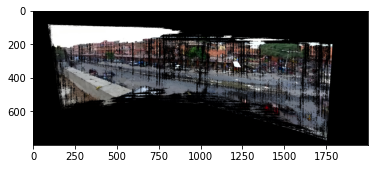

In [81]:
# TO DO part 4
# Read all the transformed frames
transformed_frames_dir = "images/output/frames"
transformed_filenames = []
transformed_filesinfo = os.scandir(transformed_frames_dir)

transformed_filenames = [f.path for f in transformed_filesinfo if f.name.endswith(".jpg")]
transformed_filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

transformed_frameCount = len(transformed_filenames)
transformed_frameHeight, transformed_frameWidth, _ = cv2.imread(transformed_filenames[0]).shape
transformed_frames = np.zeros((transformed_frameCount, transformed_frameHeight, transformed_frameWidth, 3), dtype='uint8')

for idx, file_i in enumerate(transformed_filenames):
    if idx < transformed_frameCount:
        transformed_frames[idx] = cv2.imread(file_i)

        

background_panorama = np.zeros((transformed_frameHeight, transformed_frameWidth, 3), dtype='uint8')

# data = transformed_frames[:, :, :, 0] * 256 * 256 + transformed_frames[:, :, :, 1] * 256 + transformed_frames[:, :, :, 2]
result = np.zeros((transformed_frameHeight, transformed_frameWidth), dtype=data.dtype)

from scipy import stats

for y in range(transformed_frameHeight):
    for x in range(transformed_frameWidth):
        if x == 0:
            print(y)
        oc = transformed_frames[:, y, x].astype(int)
        colors = oc[:, 0] * 256 * 256 + oc[:, 1] * 256 + oc[:, 2]

        colors = colors[colors > 0]
        if colors.shape[0] > 0:
            res, _ = stats.mode(colors)
            background_color = res[0]
        else:
            background_color = 0

        background_panorama[y, x, 2] = background_color % 256
        background_panorama[y, x, 1] = (background_color // 256) % 256
        background_panorama[y, x, 0] = (background_color // (256 * 256)) % 256




# Display the background panorama
plt.figure()
plt.imshow(background_panorama[:, :, ::-1])
plt.show()



### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [104]:
# TO DO part
output_dir = "images/output/bg_frames"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
video_frameHeight, video_frameWidth, _ = cv2.imread("./images/input/frames/f0270.jpg").shape
    
for i in range(transformed_frameCount):
    H_inv = np.linalg.inv(np.dot(Tr,all_homographies[i]))
    warped_frame = cv2.warpPerspective(background_panorama, H_inv, (video_frameWidth, video_frameHeight))
    cv2.imwrite(os.path.join(output_dir, f"f{str(i+1).zfill(4)}.jpg"), warped_frame)

utils.imageFolder2mpeg("images/output/bg_frames", "./videos/output/bg_video.mpeg")

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [112]:
# TO DO part 6
output_dir = "images/output/fg_frames"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for i in range(transformed_frameCount):
    H_inv = np.linalg.inv(np.dot(Tr,all_homographies[i]))
    bg = cv2.warpPerspective(background_panorama, H_inv, (video_frameWidth, video_frameHeight))
    img = cv2.warpPerspective(transformed_frames[i], H_inv, (video_frameWidth, video_frameHeight))
    foreground = np.zeros((video_frameHeight, video_frameWidth, 3))
    diff = np.sqrt(((bg - img) ** 2).sum(axis=-1))
    idx = np.argwhere(diff > 10)
    mask = np.zeros((video_frameHeight, video_frameWidth,3))
    mask[idx[:,0],idx[:,1],:]=1
    mask = cv2.GaussianBlur(mask, (3,3), cv2.BORDER_DEFAULT)
    
    foreground = img * mask
    cv2.imwrite(os.path.join(output_dir, f"f{str(i+1).zfill(4)}.jpg"), foreground)
    
utils.imageFolder2mpeg("images/output/fg_frames", "./videos/output/fg_video.mpeg")

## Bells and whistles

In [113]:
# TO DO part
output_dir = "images/output/wide_bg_frames"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
video_frameHeight, video_frameWidth, _ = cv2.imread("./images/input/frames/f0270.jpg").shape
video_frameWidth *= 2
    
for i in range(transformed_frameCount):
    H_inv = np.linalg.inv(np.dot(Tr,all_homographies[i]))
    warped_frame = cv2.warpPerspective(background_panorama, H_inv, (video_frameWidth, video_frameHeight))
    cv2.imwrite(os.path.join(output_dir, f"f{str(i+1).zfill(4)}.jpg"), warped_frame)

utils.imageFolder2mpeg("images/output/wide_bg_frames", "./videos/output/wide_bg_video.mpeg")